# 2. (20 points) 
A bank is implementing a system to identify potential customers who have higher probablity of availing loans to increase its profit.  
**Implement Naive Bayes classifier** on this dataset to help bank achieve its goal.  
Report your observations and accuracy of the model.
Data is available at http://preon.iiit.ac.in/~sanjoy_chowdhury/LoanDataset.zip

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from utils.datatools import train_test_split

In [2]:
def read_csv(data_file):
    df = pd.read_csv(data_file, header=None, sep=',')

    # add column names header
    df.columns = ["ID", "age", "experience", "income", "zipcode", "family size", 
                  "avg spends per month","education level", "mortgage value of house", "label",
                  "securities account", "CD account", "netbanking", "credit card"]

    df.drop(["ID", "zipcode"], axis=1, inplace=True)

    cols = df.columns.tolist()
    cols.remove("label")
    df = df[cols +["label"]]

    df.head(3)
    
    return df

df = read_csv("../data/loan/data.csv")

In [3]:
categorical_features = ["education level", "securities account", "CD account", "netbanking",
                        "credit card"] 
numerical_features = ["age", "experience", "income", "avg spends per month", 
                      "mortgage value of house"] + ["family size"]

# Data Inspection

In [4]:
def inspect_data(df):
    for col in df.columns:
        unique_vals, counts=np.unique(df[col].values, return_counts=True)
        print(col,len(unique_vals),"min:", min(unique_vals), "max:", max(unique_vals))
        if len(unique_vals)<=10:
            print(unique_vals)
            print(counts)
        print("------------------")

    print("Datframe size:", len(df))
inspect_data(df)

age 45 min: 23 max: 67
------------------
experience 48 min: -3.0 max: 43.0
------------------
income 162 min: 8 max: 224
------------------
family size 4 min: 1 max: 4
[1 2 3 4]
[1317 1173  915 1095]
------------------
avg spends per month 105 min: 0.0 max: 10.0
------------------
education level 4 min: 1.0 max: 3.0
[1.  1.2 2.  3. ]
[1882    1 1262 1355]
------------------
mortgage value of house 338 min: 0 max: 635
------------------
securities account 3 min: 0.0 max: 1.3
[0.  1.  1.3]
[4021  478    1]
------------------
CD account 3 min: 0.0 max: 1.0
[0.  0.2 1. ]
[4226    1  273]
------------------
netbanking 3 min: 0.0 max: 1.0
[0.  0.3 1. ]
[1791    1 2708]
------------------
credit card 3 min: 0.0 max: 1.0
[0.  0.4 1. ]
[3183    1 1316]
------------------
label 3 min: 0.0 max: 1.0
[0.  0.1 1. ]
[4065    1  434]
------------------
Datframe size: 4500


# Clean data

In [5]:
def clean_data(df):
    # first we cleanup categorical data
    df.loc[~df["education level"].isin([1, 2, 3]), "education level"] = df['education level'].value_counts().idxmax()
    df.loc[~df["label"].isin([0, 1]), "label"] = df['label'].value_counts().idxmax()
    df.loc[~df["securities account"].isin([0,1]), "securities account"] = df['securities account'].value_counts().idxmax()
    df.loc[~df["CD account"].isin([0,1]), "CD account"] = df['CD account'].value_counts().idxmax()
    df.loc[~df["netbanking"].isin([0,1]), "netbanking"] = df['netbanking'].value_counts().idxmax()
    df.loc[~df["credit card"].isin([0,1]), "credit card"] = df['credit card'].value_counts().idxmax()

    # Fix experience. It can't be negative
    df.loc[df.experience<0, "experience"] = df.loc[df.experience>=0, "experience"].mean()

    return df

df = clean_data(df)

In [6]:
inspect_data(df)

age 45 min: 23 max: 67
------------------
experience 46 min: 0.0 max: 43.0
------------------
income 162 min: 8 max: 224
------------------
family size 4 min: 1 max: 4
[1 2 3 4]
[1317 1173  915 1095]
------------------
avg spends per month 105 min: 0.0 max: 10.0
------------------
education level 3 min: 1.0 max: 3.0
[1. 2. 3.]
[1883 1262 1355]
------------------
mortgage value of house 338 min: 0 max: 635
------------------
securities account 2 min: 0.0 max: 1.0
[0. 1.]
[4022  478]
------------------
CD account 2 min: 0.0 max: 1.0
[0. 1.]
[4227  273]
------------------
netbanking 2 min: 0.0 max: 1.0
[0. 1.]
[1791 2709]
------------------
credit card 2 min: 0.0 max: 1.0
[0. 1.]
[3184 1316]
------------------
label 2 min: 0.0 max: 1.0
[0. 1.]
[4066  434]
------------------
Datframe size: 4500


#### Probability matrix structure
```python
{
    feature_name:
         {
             feat_val1: 
                {
                    Class1: Prob,
                    Class2: prob
                }
         },
    numerical_feature_name:
        {
            mean:
                {
                    class1: Prob,
                    class2: Prob
                },
            std:
                {
                    class1: Prob,
                    class2: Prob
                }
        }
}
```

In [7]:
def naive_bayes_algo(df):
    global probability_matrix
    probability_matrix = {}
    
    unique_classes = np.unique(df["label"])

    for feature_name in df.columns:
        if feature_name in categorical_features:
            if feature_name not in probability_matrix:
                probability_matrix[feature_name] = {}

            unique_values = np.unique(df[feature_name].values)
            for feature_val in unique_values:
                if feature_val not in probability_matrix[feature_name]:
                    probability_matrix[feature_name][feature_val] = {}

                for class_value in unique_classes:
                    if class_value not in probability_matrix[feature_name][feature_val]:
                        probability_matrix[feature_name][feature_val][class_value] = 0

                    probability_matrix[feature_name][feature_val][class_value] = conditional_probability((feature_name, feature_val), ("label", class_value))

        elif feature_name in numerical_features:
            if feature_name not in probability_matrix:
                probability_matrix[feature_name] = {"mean":{}, "std":{}}
                # find mean and standard deviation
                for class_value in  unique_classes:
                    probability_matrix[feature_name]["mean"][class_value] = df[df["label"]==class_value][feature_name].mean()

                for class_value in  unique_classes:
                    probability_matrix[feature_name]["std"][class_value] = df[df["label"]==class_value][feature_name].std()

In [8]:
def conditional_probability(feature, class_label):
    """Returns conditional probability P(A|B) = P(A and B) / P(B) = n(A and B) / n(B)"""
    feature_name, feature_value = feature
    class_name, class_value = class_label # for our purposes class_name will always be "label" and value can be 0 or 1
    n_A_and_B = len(df[(df[feature_name]==feature_value) & (df[class_name]==class_value)]) 
    n_B = len(df[df[class_name]==class_value])
    return n_A_and_B / n_B
    
    
    
def probability(df, feature_name, feature_value):
    # P(A) = n(A) / n(Sample space)
    return len(df[df[feature_name]==feature_value]) / len(df)

In [9]:
# from pprint import pprint
# pprint(probability_matrix)

In [10]:
import math
def normpdf(x, mean, sd):
    numerator = math.exp(-(x-mean)**2 / (2*(sd ** 2)))
    denominator = ((2 * math.pi)**.5) * sd

    return numerator / denominator

In [11]:
from math import log

def get_likelihood(example, probability_matrix, class_label, columns):
    likelihood = 1
    for feature_name in columns:
        feature_value = example[feature_name]
        
        if feature_name in categorical_features:
            prob = probability_matrix[feature_name][feature_value][class_label]
            
        elif feature_name in numerical_features:
            mean = probability_matrix[feature_name]["mean"][class_label]
            std = probability_matrix[feature_name]["std"][class_label]
            prob = normpdf(feature_value,mean, std)
        
        likelihood += log(prob)

    return likelihood

In [12]:
from math import log 

def classify_example(example, train_df, columns):
    unique_labels = np.unique(train_df["label"].values)
    posterior_probabilities = []
    
    for class_label in unique_labels:
        posterior = get_likelihood(example, probability_matrix, class_label, columns) \
                        + log(probability(train_df, "label", class_label))
        posterior_probabilities.append(posterior)
    
    max_prob  = max(posterior_probabilities)
    idx = posterior_probabilities.index(max_prob)
    return unique_labels[idx]


def predict(test_df, train_df):
    predictions = test_df.apply(classify_example, axis=1, args=(train_df, test_df.columns))
    predictions.name = "classification"
    return predictions

accuracy 0.9044444444444445


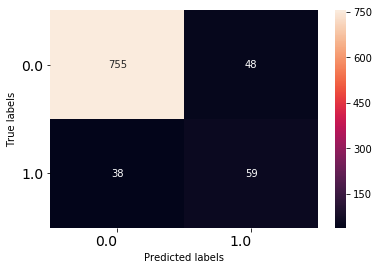

In [13]:
train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=2)
naive_bayes_algo(train_df)
predictions = predict(validate_df, train_df)

actual = validate_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

from utils.metrics import accuracy
print("accuracy", accuracy(combined_df))

from utils.plotter import plot_confusion_heatmap
plot_confusion_heatmap(combined_df,xticks_rotation=0)

# Load test data from supplied command line path

In [14]:
import sys
if len(sys.argv) != 2:
    print("Please supply test file path")
    exit(1)

test_file_path = sys.argv[1]
print("Loading test data from:", test_file_path)


Please supply test file path
Loading test data from: -f


accuracy 0.9071111111111111


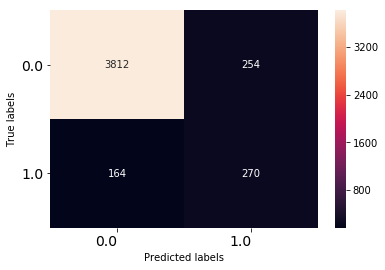

In [15]:
# STOPSHIP
if test_file_path == "-f":
    test_file_path = "../data/loan/data.csv"
    
test_df = read_csv(test_file_path)
test_df = clean_data(test_df)

predictions = predict(test_df, train_df)

actual = test_df["label"]
combined_df = pd.concat([actual, predictions],axis=1)

from utils.metrics import accuracy
print("accuracy", accuracy(combined_df))

from utils.plotter import plot_confusion_heatmap
plot_confusion_heatmap(combined_df,xticks_rotation=0)